# Example: Crameri et al. (2012) - Case 2

The Case 2 experiment presented by Crameri et al. (2012) evaluates the sticky air method to obtain a numerical surface topography in geodynamic modelling.

The experiment analyses the change in topography due to the rising of a mantle plume.
The model setup consists of a 2800 km by 850 km box with a 150 km sticky air layer on the top of the model.
The mantle thickness is 600 km with a 100 km thick lithosphere.
The lithosphere density is 3300 kg/m<sup>3</sup> with viscosity 10<sup>23</sup> Pa.s,
the mantle density is 3300 kg/m<sup>3</sup> with viscosity 10<sup>21</sup> Pa.s
and the mantle plume density is 3200 kg/m<sup>3</sup> with viscosity 10<sup>20</sup> Pa.s.

Initially, the center of the plume is horizontally centered and 300 km above the base of the model.
At the top, the sticky air layer has density 0 kg/m<sup>3</sup> with viscosity 10<sup>19</sup> Pa.s.
A free slip boundary condition is applied to the upper boundary of the sticky air layer and the vertical sides of the model and the base are kept fixed.
There is no temperature difference, and the geodynamic evolution is guided solely by compositional density differences.

## Generate input files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Shape of the model

In [2]:
# total model horizontal extent (m)
Lx = 2800.0e3

# total model vertical extent (m)
Lz = 850.0e3

# number of points in horizontal direction
Nx = 281

# number of points in vertical direction
Nz = 169

In [3]:
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)

### Define the thickness of the layers and the plume

They are in meters.

In [4]:
# Thickness of sticky air layer
thickness_sa = 150.0e3

# Thickness of lid
thickness_lid = 100.0e3

# Plume diameter
diameter_plume = 100.0e3

# Plume center (above the bottom)
center_plume = 300.0e3

### Create the interfaces (bottom first)

Create the plume interfaces:

In [5]:
# Horizontal position where start and finish the plume
x_plume_left = int(
    ((Lx - diameter_plume) / 2) / (Lx / (Nx - 1))
)
x_plume_right = int(
    ((Lx + diameter_plume) / 2) / (Lx / (Nx - 1))
)

# Plume interfaces
plume_bottom = -1 * np.ones(Nx) * (Lz - center_plume)

plume_bottom[x_plume_left : x_plume_right] = -1 * (Lz - center_plume) - np.sqrt(
    diameter_plume**2 / 4 - (x[x_plume_left : x_plume_right] - Lx / 2)**2
)

plume_top = -1 * np.ones(Nx) * (Lz - center_plume)

plume_top[x_plume_left:x_plume_right] = -1 * (Lz - center_plume) + np.sqrt(
    diameter_plume**2 / 4 - (x[x_plume_left : x_plume_right] - Lx / 2)**2
)

In [6]:
interfaces = {
    "plume_bottom": plume_bottom,
    "plume_top": plume_top,
    "mantle_top": -1 * (np.ones(Nx) * (thickness_sa + thickness_lid)),
    "lid_top": -1 * (np.ones(Nx) * (thickness_sa)),
}

Plot the interfaces:

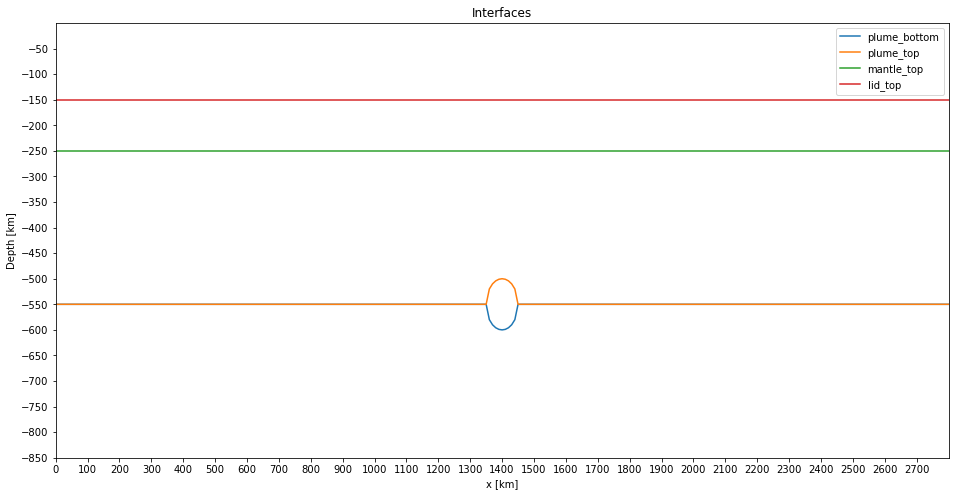

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
    ax.plot(x / 1.0e3, layer / 1.0e3, label=f"{label}")

ax.set_xticks(np.arange(0, Lx / 1.0e3, 100))
ax.set_yticks(np.arange(-Lz / 1.0e3, 0, 50))

ax.set_xlim([0, Lx / 1.0e3])
ax.set_ylim([-Lz / 1.0e3, 0])

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces")
plt.legend()
plt.show()


#### Create the interface file

The interface file contain the layer properties and the interface's depth between these layers. 

Layer properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (v)

In [8]:
# Create and save the interface file:
with open("interfaces.txt", "w") as f:
    layer_properties = f"""
        C   1.0    0.1    1.0    100.0  0.01
        rho 3300.0 3200.0 3300.0 3300.0 0.0
        H   0.0    0.0    0.0    0.0    0.0
        A   0.0    0.0    0.0    0.0    0.0
        n   0.0    0.0    0.0    0.0    0.0
        Q   0.0    0.0    0.0    0.0    0.0
        V   0.0    0.0    0.0    0.0    0.0
    """

    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # Layer interfaces
    data = np.array(tuple(interfaces.values())).T
    np.savetxt(f, data, fmt="%f")

### Create the parameter file

In [9]:
params = f"""# Geometry
nx                                  = {Nx}           # Number of elements in the longitudinal direction
nz                                  = {Nz}           # Number of elements in the vertical direction
lx                                  = {Lx:.1e}       # Extent in the longitudinal direction
lz                                  = {Lz:.1e}       # Extent in the vertical direction

# Simulation options
multigrid                           = 1
solver                              = direct        # default is direct [direct/iterative]
denok                               = 1.0e-15       # default is 1.0E-4
particles_per_element               = 600           # default is 81
particles_per_element_x             = 6             # Number of particles per element in longitudinal (default is 0)
particles_per_element_z             = 100           # Number of particles per element in vertical (default is 0)
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-14       # default is 1.0E-14
random_initial_strain               = 0.0           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = False         # default is False [True/False]
periodic_boundary                   = False         # default is False [True/False]
high_kappa_in_asthenosphere         = False         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = -1.0          # default is -1.0

# Surface processes
sp_surface_tracking                 = True          # default is False [True/False]
sp_surface_processes                = False         # default is False [True/False]
sp_mode                             = 0             # default is 1 [0/1/2]
sp_dt                               = 0             # default is 0.0
sp_d_c                              = 0.0           # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]

free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)

# Time constrains
step_max                            = 7000          # Maximum time-step of the simulation
time_max                            = 21.0e6        # Maximum time of the simulation [years]
dt_max                              = 10.0e3        # Maximum time between steps of the simulation [years]
step_print                          = 10            # Make file every <step_print>
sub_division_time_step              = 1.0           # default is 1.0
initial_print_step                  = 2             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0e6 [years]

# Viscosity
viscosity_reference                 = 1.0e21        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e23        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e19        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic    # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}             # Number of interfaces in the 'interfaces.txt' file
variable_bcv                        = False         # default is False [True/False]
temperature_from_ascii              = False         # default is False [True/False]
velocity_from_ascii                 = False         # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = False         # default is False [True/False]
precipitation_profile_from_ascii    = False         # default is False [True/False]
climate_change_from_ascii           = False         # default is False [True/False]

print_step_files                    = True          # default is True [True/False]
checkered                           = False         # Print one element in the print_step_files (default is False [True/False])

geoq                                = on
geoq_fac                            = 100.0

# Physical parameters
temperature_difference              = 0.0
thermal_expansion_coefficient       = 3.28e-5
thermal_diffusivity_coefficient     = 1.0e-6
gravity_acceleration                = 10.0
density_mantle                      = 3300.0
external_heat                       = 0.0e-12
heat_capacity                       = 1250.0

non_linear_method                   = off
adiabatic_component                 = off
radiogenic_component                = on

# Velocity boundary conditions
top_normal_velocity                 = fixed
top_tangential_velocity             = free
bot_normal_velocity                 = fixed
bot_tangential_velocity             = fixed
left_normal_velocity                = fixed
left_tangential_velocity            = free
right_normal_velocity               = fixed
right_tangential_velocity           = free

surface_velocity                    = 0.0
multi_velocity                      = False         # default is False [True/False]

# Temperature boundary conditions
top_temperature                     = fixed
bot_temperature                     = fixed
left_temperature                    = fixed
right_temperature                   = fixed

rheology_model                      = 0
T_initial                           = 0
"""

# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        f.write(line + "\n")

## Run the model 

You can run the model as:

```
mpirun -n NUMBER_OF_CORES mandyoc
```

*You have to change NUMBER_OF_CORES.*


## Post-processing

### Plot the results

Determine the initial and final step to make the plots:

In [10]:
step_initial = 0
step_final = 2000

d_step = 400

Load the parameter file to generate the grid of the model:

In [11]:
with open("param.txt", "r") as f:
    line = f.readline()
    line = f.readline()
    line = line.split()
    Nx = int(line[2])
    line = f.readline()
    line = line.split()
    Nz = int(line[2])
    line = f.readline()
    line = line.split()
    Lx = float(line[2])
    line = f.readline()
    line = line.split()
    Lz = float(line[2])
    
print(
    "nx:", Nx, "\n",
    "nz:", Nz, "\n",
    "Lx:", Lx, "\n",
    "Lz:", Lz
)

nx: 281 
 nz: 169 
 Lx: 2800000.0 
 Lz: 850000.0


In [12]:
xi = np.linspace(0, Lx / 1e3, Nx)
zi = np.linspace(-Lz / 1e3, 0, Nz)

xx, zz = np.meshgrid(xi, zi)

0
Step = 0
Time = 0.0 Myr


strain 0.0 0.0
strain(log) -inf -inf


/tmp/ipykernel_18032/2251032914.py:33: RuntimeWarning: divide by zero encountered in log10
  visco_log = np.log10(visco)
/tmp/ipykernel_18032/2251032914.py:49: RuntimeWarning: divide by zero encountered in log10
  strain_log = np.log10(strain)


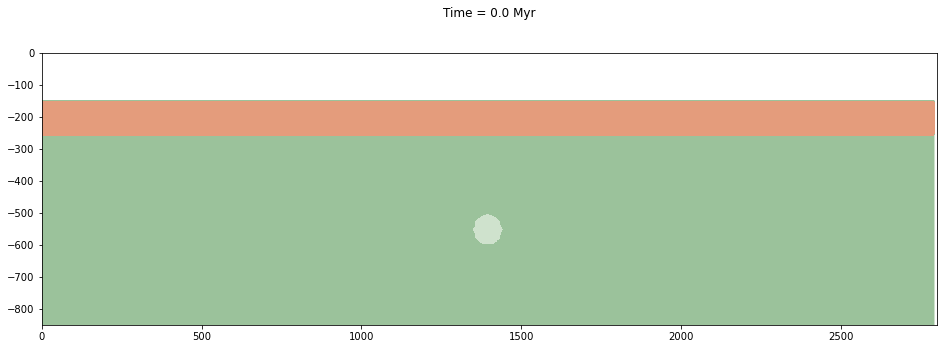

400
Step = 400
Time = 4.0 Myr


strain 0.0 1.34619
strain(log) -inf 0.1291063601317734


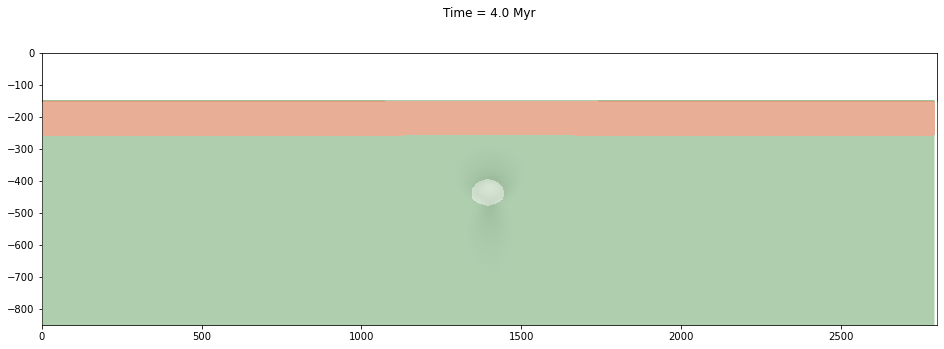

800
Step = 800
Time = 8.0 Myr


strain 0.0 2.32139
strain(log) -inf 0.36574810927083445


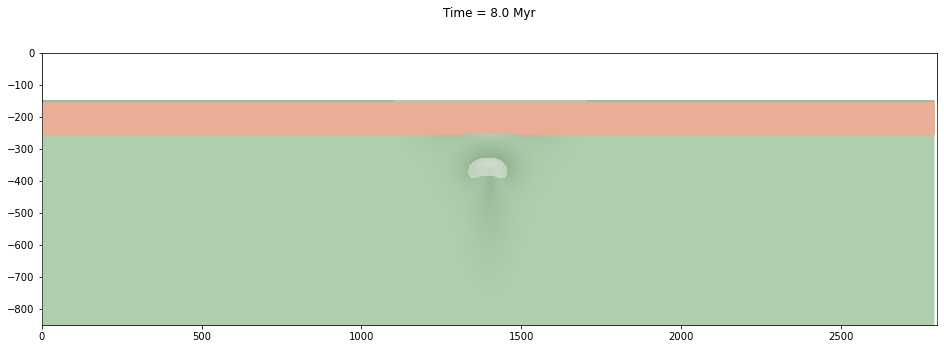

1200
Step = 1200
Time = 12.0 Myr


strain 0.0 2.93561
strain(log) -inf 0.46769835843126395


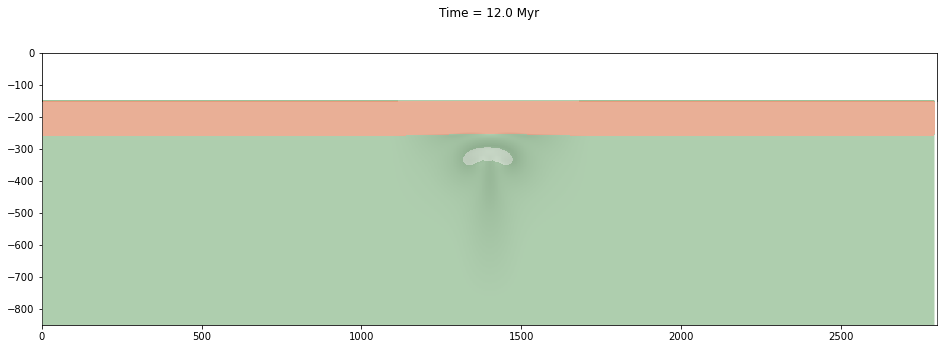

1600
Step = 1600
Time = 16.0 Myr


strain 0.0 3.25188
strain(log) -inf 0.512134510999709


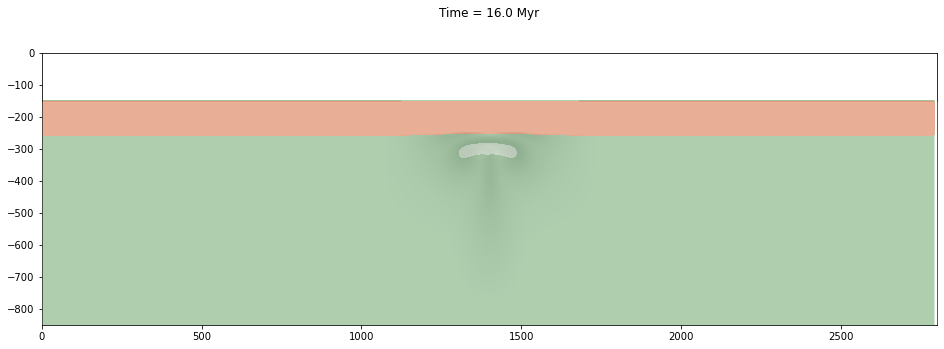

2000
Step = 2000
Time = 20.0 Myr


strain 0.0 3.40939
strain(log) -inf 0.532676683000725


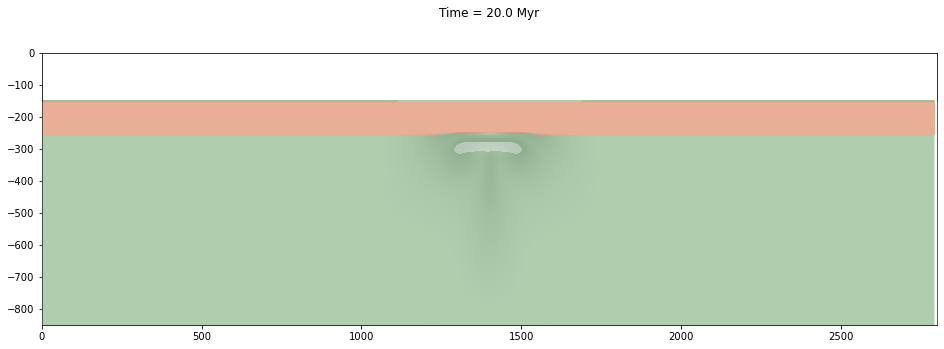

In [13]:
for cont in range(step_initial, step_final + d_step, d_step):  #
    print(cont)
    
    # Read time
    time = np.loadtxt("time_" + str(cont) + ".txt", dtype="str")
    time = time[:, 2:]
    time = time.astype("float")

    # Read density
    rho = pd.read_csv(
        "density_" + str(cont) + ".txt",
        delimiter=" ",
        comment="P",
        skiprows=2,
        header=None,
    )
    rho = rho.to_numpy()
    rho[np.abs(rho) < 1.0e-200] = 0
    rho = np.reshape(rho, (Nx, Nz), order="F")
    rho = np.transpose(rho)

    # Read viscosity
    visco = pd.read_csv(
        "viscosity_" + str(cont) + ".txt",
        delimiter=" ",
        comment="P",
        skiprows=2,
        header=None,
    )
    visco = visco.to_numpy()
    visco = np.reshape(visco, (Nx, Nz), order="F")
    visco = np.transpose(visco)
    visco_log = np.log10(visco)
    visco_log[visco_log == -np.inf] = 0
    
    # Read strain
    strain = pd.read_csv(
        "strain_" + str(cont) + ".txt",
        delimiter=" ",
        comment="P",
        skiprows=2,
        header=None,
    )
    strain = strain.to_numpy()
    strain[np.abs(strain) < 1.0e-200] = 0
    strain = np.reshape(strain, (Nx, Nz), order="F")
    strain = np.transpose(strain)
    strain[rho < 200] = 0
    strain_log = np.log10(strain)
    
    print("Step =", cont)
    print("Time = %.1lf Myr\n\n" % (time[0] / 1.0e6))
    print("strain", np.min(strain), np.max(strain))
    print("strain(log)", np.min(strain_log), np.max(strain_log))
    
    plt.figure(figsize=(20, 5))
    plt.title("Time = %.1lf Myr\n\n" % (time[0] / 1.0e6))
    
    # Create the colors to plot the density
    cr = 255.0
    color_plume = (207.0 / cr, 226.0 / cr, 205.0 / cr)
    color_mantle = (155.0 / cr, 194.0 / cr, 155.0 / cr)
    color_lid = (228.0 / cr, 156.0 / cr, 124.0 / cr)
    colors = [color_plume, color_mantle, color_lid]
    
    # Plot density
    plt.contourf(
        xx,
        zz,
        visco_log,
        levels=[19.5, 20.5, 21.5, 23.5],
        colors=colors,
    )
    
    # plot strain_log
    plt.imshow(
        strain_log[::-1, :],
        extent=[np.min(xx), np.max(xx), np.min(zz), np.max(zz)],
        zorder=100,
        alpha=0.2,
        cmap=plt.get_cmap("Greys"),
        vmin=-0.5,
        vmax=0.9,
    )

    

    plt.show()